# Домашнее задание 1

Это домашнее задание по материалам первого семинаров. Дедлайн по отправке - 23:55 10 февраля. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_1

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим следуюущую задачу оптимизации:
\begin{equation}
\min_{x \in \mathbb{R}^d} \left[f(x) := \tfrac{1}{2} x^T A x - b^T x\right],
\end{equation}
где $A \in \mathbb{R}^{d \times d}$, $b \in \mathbb{R}^d$.

__(а)__ Является ли данная задача всегда выпуклой/сильной выпуклой? При каких условиях?

найдем гессиан в этой задаче 

$df = \frac{1}{2}d(x, Ax) - d(b, x) = \frac{1}{2}(Ax, dx) + \frac{1}{2}(A^{T}x, dx) - (b, dx) = (\frac{1}{2}(A + A^{T})x - b, dx)$ 

$d^2f = d((\frac{1}{2}(A + A^{T})x - b, dx_{1})) = ((\frac{1}{2}(A + A^{T}), dx_{1}), dx)$ 

$\nabla^2f(x) = \frac{1}{2}(A + A^{T})$  

Итак, наша функция выпукла, если матрица квадратичной формы $A + A^T$ -положительно полуопределена, и сильно выпукла, если матрица квадратичной формы $A + A^T$ - положительно определена. 

__(б)__ Оцените для этой функции константу сильной выпуклости и константу Липшица градиента.

$\frac{1}{2}(A + A^T) \geq \mu E$  

$||\nabla f(x) - \nabla f(x_{0})|| \leq L||x - x_{0}||$ 

$||\frac{1}{2}(A + A^{T})(x - x_{0})|| \leq L ||x - x_{0}||$ 

Таким образом, имеем что $\mu = \lambda_{min}(\frac{1}{2}(A + A^{T}))$,  $L = \lambda_{max}(\frac{1}{2}(A + A^{T}))$

вот такая оценка на константу Липшица. 

## Задача 2

Продолжаем работать с задачей оптимизации из предыдущей задачи.

__(а)__ Придумайте (или найдите) способ генерации матрицы $А$, так чтобы $f$ была сильно выпуклой, а также можно было задавать и менять $d, \mu, L$.

In [1]:
import random 

random.seed(777)

In [77]:
import numpy as np 
from numpy import linalg 

def rvs(dim=3):
     random_state = np.random
     H = np.eye(dim)
     D = np.ones((dim,))
     for n in range(1, dim):
         x = random_state.normal(size=(dim-n+1,))
         D[n-1] = np.sign(x[0])
         x[0] -= D[n-1]*np.sqrt((x*x).sum())
         # Householder transformation
         Hx = (np.eye(dim-n+1) - 2.*np.outer(x, x)/(x*x).sum())
         mat = np.eye(dim)
         mat[n-1:, n-1:] = Hx
         H = np.dot(H, mat)
     D[-1] = (-1)**(1-(dim % 2))*D.prod()
     H = (D*H.T).T
     return H
    
def generate_matrix(d, m, L):  
    A = np.eye(d) 
    A[0, 0] = L
    A[1, 1] = m
    S = rvs(d) 
    A = np.dot(np.linalg.inv(S), np.dot(A, S))
    return A 

In [78]:
print(generate_matrix(5, -10, 5))

[[-1.41665723 -3.07194165  1.65814576  1.74177102  2.57594948]
 [-3.07194165 -1.6448714   0.55374702  1.59764965  4.38691549]
 [ 1.65814576  0.55374702  1.77886212 -0.43486534 -3.13947963]
 [ 1.74177102  1.59764965 -0.43486534  0.04618947 -2.40080648]
 [ 2.57594948  4.38691549 -3.13947963 -2.40080648 -0.76352297]]


In [79]:
print(np.linalg.eigvals(generate_matrix(5, -10, 200)))

[200.   1. -10.   1.   1.]


__(б)__ Реализуйте метод градиетного спуска:
\begin{equation}
x_{k+1} = x_k - \gamma_k \nabla f(x_k),
\end{equation}
для квадратичной функции с матрицей, которую сгенерировали выше и произвольным вектором $b$ (лучше ненулевым). Желательно, уже сейчас и метод, и подсчет градиента реализовывать, как отдельные функции, при этом чтобы метод принимал саму целевую функцию (или ее градиент), как параметр. В дальнейшем будет легче менять целевую функцию в задаче минимизации и тестировать разные методы. 

In [104]:
class GradientDescent: 
    def __init__(self, d, m, L, b, iterations, alpha): 
        self.max_steps = iterations 
        self.alpha = alpha
        self.x = None 
        self.converges_history = [] 
        self.A = generate_matrix(d, m, L)   
        self.m = m 
        self.d = d 
        self.L = L  
        self.b = b  
        self.converge = False
    
    def grad(self, x): 
        return 1/2 * np.dot((self.A + self.A.T), x) - self.b  
    
    def criteria(self, x_true): 
        return np.linalg.norm(x_true - self.x)**2 
    
    def fit(self, x_true): 
        self.x = np.zeros(self.d) 
        new_x = np.zeros(self.d)
        for i in range(self.max_steps):  
            self.converges_history.append(self.criteria(x_true))
            new_x = self.x - self.alpha * self.grad(self.x) 
            self.x = new_x  
        return self    
    
    def function(self, x): 
        return 1/2 * np.dot(x, np.dot(self.A, x)) - np.dot(self.b, x)
    
    def better_fit(self):  
        self.x = np.zeros(self.d)
        new_x = np.zeros(self.d)
        for i in range(self.max_steps):  
            self.converges_history.append(np.linalg.norm(self.x - new_x)**2)
            new_x = self.x - self.alpha * self.grad(self.x) 
            if(np.linalg.norm(self.x - new_x)**2 < 1e-4): 
                self.converge = True
            self.x = new_x  
        return self   
    
    def fit_function(self): 
        self.x = np.zeros(self.d)
        new_x = np.zeros(self.d) 
        for i in range(self.max_steps): 
            self.converges_history.append(np.linalg.norm(self.function(self.x) - self.function(new_x))**2) 
            new_x = self.x - self.alpha * self.grad(self.x)
            self.x = new_x 
        return self
    
    def check(self, x_true): 
        if(self.criteria(x_true) < 1e-4):  
            self.converge = True   
            

__(в)__ Для задачи с $d = 10$, $\mu = 1$ и $L = 100$ найдите точное решение $x^*$, например, с помощью пакетов линейной алгебры (есть встроенный в numpy). Запустите градиентный спуск на $10^4$ итераций с шагом $\gamma_k = \tfrac{1}{L}$ и произвольной начальной точкой $x_0$ (если $b$ ненулевой, то можно взять нулевой $x_0$). Проверьте сходится ли он. В качестве критериев сходимости используйте $\| x_k - x^*\|^2$.

In [105]:
gd = GradientDescent(10, 1, 100, np.random.normal(size=(10, )), int(1e+4), 1/100)  
x_true = 2 * np.dot(np.linalg.inv(gd.A + gd.A.T), gd.b)
gd.fit(x_true)  
gd.check(x_true)
if(gd.converge == True): 
    print("converges") 
else: 
    print("Not converges") 

converges


__(г)__ Постройте график сходимости: по оси $x$ отложите номер итерации, по $y$ значения критерия на этой итерации. Поиграйтесь с осями, например, поставьте по $y$ логарифмический масштаб. Не забудьте подписать оси. Сделайте вывод о характере сходимости.

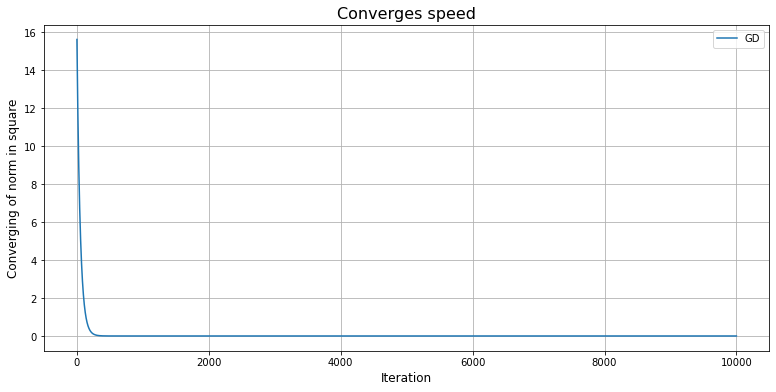

In [106]:
import matplotlib.pyplot as plt   
plt.figure(figsize=(13, 6)) 
plt.plot(range(int(1e+4)), gd.converges_history, label='GD') 
plt.title('Converges speed', fontsize=16) 
plt.legend() 
plt.xlabel('Iteration', fontsize=12) 
plt.ylabel('Converging of norm in square', fontsize=12) 
plt.grid() 
plt.show()

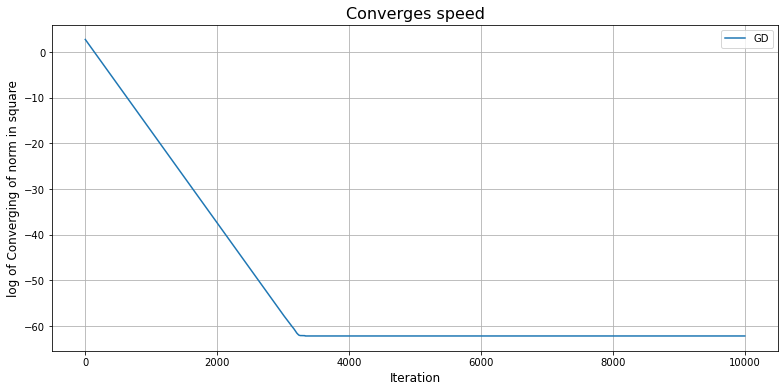

In [107]:
plt.figure(figsize=(13, 6)) 
plt.plot(range(int(1e+4)), np.log(gd.converges_history), label='GD') 
plt.title('Converges speed', fontsize=16) 
plt.legend() 
plt.xlabel('Iteration', fontsize=12) 
plt.ylabel('log of Converging of norm in square', fontsize=12) 
plt.grid() 
plt.show()

__(д)__ Добавьте на график теоретическую сходимость, полученную на семинаре. Добавьте легенду, чтобы можно было отличить, какой график за что отвечает. Сделайте вывод.

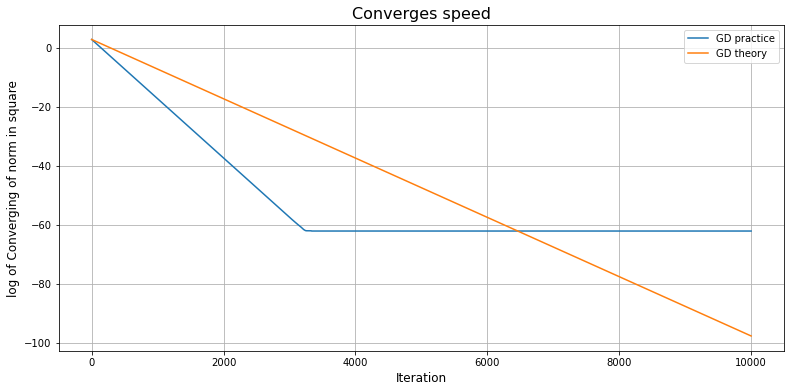

In [108]:
#ответ 
import matplotlib.pyplot as plt   
plt.figure(figsize=(13, 6)) 
plt.plot(range(int(1e+4)), np.log(gd.converges_history), label='GD practice')  

theoretical_criteria = [] 
theoretical_criteria.append(np.dot(x_true, x_true))
for i in range(int(1e+4) - 1): 
    theoretical_criteria.append(theoretical_criteria[-1] * (1 - gd.m/gd.L))  
    
plt.plot(range(int(1e+4)), np.log(theoretical_criteria), label='GD theory')
plt.title('Converges speed', fontsize=16) 
plt.legend() 
plt.xlabel('Iteration', fontsize=12) 
plt.ylabel('log of Converging of norm in square', fontsize=12) 
plt.grid() 
plt.show()

__(e)__ Попробуйте метод с разными шагами (но постоянными в одном запуске) $\gamma_k = \gamma$. Уменьшайте и увеличивайте шаг. Нанесите все новые запуски на график (теоретическую сходимость можно убрать). 

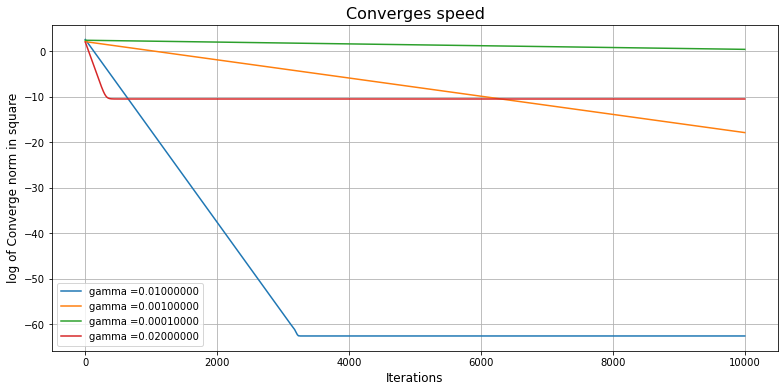

In [114]:
alphas = [0.01, 0.001, 0.0001, 0.02]  
plt.figure(figsize=(13, 6))  
for al in alphas:
    gd = GradientDescent(10, 1, 100, np.random.normal(size=(10, )), int(1e+4), al) 
    x_true = 2 * np.dot(np.linalg.inv(gd.A + gd.A.T), gd.b)
    gd.fit(x_true)
    plt.plot(range(int(1e+4)), np.log(gd.converges_history), label='gamma =%5.8f' % al)  
plt.title('Converges speed', fontsize=16) 
plt.legend()  
plt.xlabel('Iterations', fontsize=12) 
plt.ylabel('log of Converge norm in square', fontsize=12) 
plt.grid()   
plt.show()

__(ж)__ Для задачи с $\mu = 0$ и $L = 1000$, проделайте те же действия, что и в пунктах (в), (г) с числом итераций равным $10^5$. Сделайте вывод.

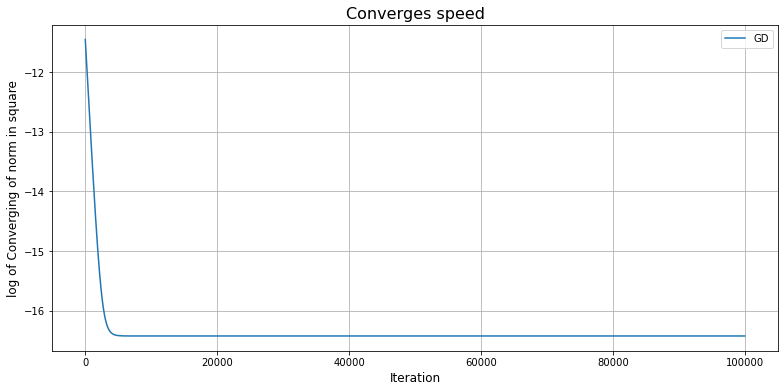

In [102]:
gd = GradientDescent(10, 0, 1000, np.random.normal(size=(10, )), int(1e+5), 1/1000)  
gd.better_fit()  
plt.figure(figsize=(13, 6)) 
plt.plot(range(int(1e+5)), np.log(gd.converges_history), label='GD') 
plt.title('Converges speed', fontsize=16) 
plt.legend() 
plt.xlabel('Iteration', fontsize=12) 
plt.ylabel('log of Converging of norm in square', fontsize=12) 
plt.grid() 
plt.show() 

__(з)__ Все ли получилось в предыдущем пункте? Если нет, то поясните почему (если это еще не сделано в выводах прошлого пункта). Проделайте пункты (в)-(e), но с критерием сходимости $f(x_k) - f(x^*)$ и/или $f(\bar x_k) - f(x^*)$ (здесь $\bar x_k$ - средняя точка на текущей и предыдущих итерациях). Сделайте вывод.

Все получилось, потому что смотрел на норму разности соседних координат, если же апроксимировать матрицу маленьким значением $\mu$, то мы не успеем обучиться, так решений не одно, и оно может оказаться бесконечно большим из за того что Rank(A) $\neq$ A

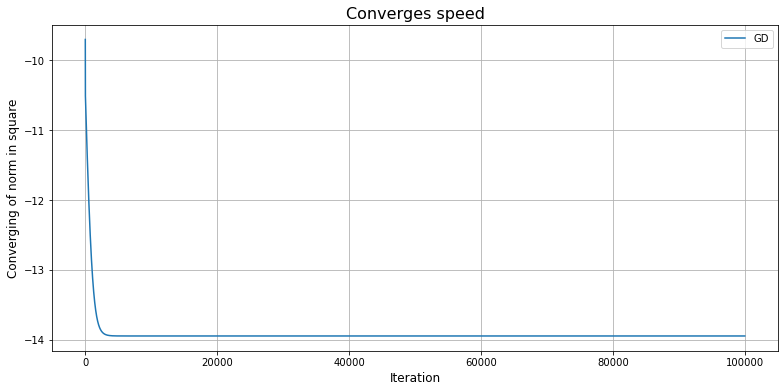

In [103]:
gd = GradientDescent(10, 0, 1000, np.random.normal(size=(10, )), int(1e+5), 1/1000)  
gd.fit_function()  
plt.figure(figsize=(13, 6)) 
plt.plot(range(int(1e+5)), np.log(gd.converges_history), label='GD') 
plt.title('Converges speed', fontsize=16) 
plt.legend() 
plt.xlabel('Iteration', fontsize=12) 
plt.ylabel('Converging of norm in square', fontsize=12) 
plt.grid() 
plt.show() 

Что то не получается получить аналитическое решение, решил сделать итеративным,  как и в прошлом пункте. 

__Бонусные пункт__

Исследуйте другие техники подбора шага, озвученные на семинаре: 

1) Уменьшающийся с номером итерации шаг,

2) Наискорейший спуск: $\gamma_k = \arg\min_{\gamma} f(x_k - \gamma \nabla f(x_k))$,

3) Правила Армихо, Вульфа и Гольдстейна: смотри параграф 3.1 из https://www.csie.ntu.edu.tw/~r97002/temp/num_optimization.pdf,

4) Шаг Поляка-Шора: $\gamma_k = \tfrac{f(x^k) - f(x^*)}{\alpha \|\nabla f(x^k)\|^2}$, где $\alpha \geq 1$.

Эксперименты нужно провести, как для сильно выпуклых, так и выпуклых задач. Сравните не только число итераций, но и время работы методов. Учтите, что правила Армихо, Вульфа, Гольстейна и Поляка-Шора требуют подбора дополнительных параметров эврестически (поиграйте с этими параметрами отдельно и выберете какой подходит лучше).

In [ ]:
#ответ 
# Will be soon